# ControlNet Quality Metric using SAM Segmentation & Hungarian Matching

This notebook evaluates the quality of ControlNet image generation by:
1. **Extracting segments** from the original COCO segmentation map (colored regions)
2. **Segmenting** the two generated images using SAM (Segment Anything Model):
   - ControlNet + Spatial Conditioning (conditioned on segmentation maps)
   - ControlNet without Spatial Conditioning
3. **Treating all segments as class-agnostic** (same class)
4. **Using Hungarian algorithm** to find optimal segment matching
5. **Computing maximum IoU** between matched segments

**Key Insight**: The original image is a segmentation map from COCO dataset with colored regions. We extract masks from these colored regions and match them against SAM-generated masks from the two generated images using Hungarian matching to maximize IoU.

## 1. Install Required Dependencies

In [3]:
!pip install -q torch torchvision
!pip install -q opencv-python matplotlib scipy "numpy<2"
!pip install -q pillow
# %pip install -q git+https://github.com/facebookresearch/segment-anything-2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 31.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.


In [ ]:
! git clone https://github.com/facebookresearch/segment-anything-2.git

import sys
# Make sure to run this AFTER cloning the repo to /kaggle/working/segment-anything-2
sys.path.append("/kaggle/working/segment-anything-2")

%cd segment-anything-2
! pip install -e . -q
%cd ..

## 2. Import Libraries

In [4]:
import os
import urllib.request
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2
from PIL import Image
import numpy as np

## 3. Download and Load SAM Model


In [5]:
# -------------------------------------------------------
# Configuration (MODIFIED)
# -------------------------------------------------------

SAM2_MODELS = {
    "large": {
        "url": "https://dl.fbaipublicfiles.com/segment_anything_2/sam2_hiera_large.pt",
        "checkpoint": "sam2_hiera_large.pt",
        "model_type": "sam2_hiera_large",
        "config_alias": "sam2_hiera_l"  # <--- ADDED: Short alias for Hydra
    },
    "base": {
        "url": "https://dl.fbaipublicfiles.com/segment_anything_2/sam2_hiera_base.pt",
        "checkpoint": "sam2_hiera_base.pt",
        "model_type": "sam2_hiera_base",
        "config_alias": "sam2_hiera_b+"  # <--- ADDED: Short alias for Hydra
    }
}

MODEL_SIZE = "base"  # change to "base" or "large"
checkpoint_path = SAM2_MODELS[MODEL_SIZE]["checkpoint"]
model_type = SAM2_MODELS[MODEL_SIZE]["model_type"]
config_file = SAM2_MODELS[MODEL_SIZE]["config_alias"] # <--- NEW: Get alias dynamically

# -------------------------------------------------------
# Download checkpoint if needed (NOTE: Check the HTTP 403 error solution here)
# -------------------------------------------------------

# NOTE: The urllib.request.urlretrieve may still fail with HTTP Error 403.
# You MUST replace the urllib block below with the recommended `wget` or `requests` solution
# from the previous turn to handle the 403 error.
if not os.path.exists(checkpoint_path):
    print("Downloading SAM 2 model...")
    # --- START of Recommended Download Fix ---
    SAM2_MODEL_URL = SAM2_MODELS[MODEL_SIZE]["url"]
    # Using wget is the most direct fix for 403 in a notebook:
    ! wget -q --user-agent="Mozilla/5.0" {SAM2_MODEL_URL} -O {checkpoint_path}
    
    if os.path.exists(checkpoint_path):
        print("Download complete!")
    else:
        print("Download failed with wget. Check connection/URL.")
    # --- END of Recommended Download Fix ---
else:
    print(f"SAM 2 model already exists: {checkpoint_path}")


# -------------------------------------------------------
# Load model (CORRECTED)
# -------------------------------------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 1. Build the core SAM-2 model
sam_core = build_sam2(
    model_type=model_type,
    checkpoint=checkpoint_path,
    config_file=config_file,  # <--- USES THE DYNAMIC ALIAS
    device=device
)

sam_core.to(device) # Move model to GPU/CPU

# 2. Wrap the core model in the Predictor class
# The sam variable should now be the predictor instance
sam = SAM2ImagePredictor(sam_core) # Renamed to sam_predictor for clarity

print("SAM 2 predictor loaded successfully!")

SAM 2 model already exists: sam2_hiera_base.pt
Using device: cuda
SAM 2 predictor loaded successfully!


## 4. Configure Image Paths

**Replace these paths with your actual image paths:**
- `original_segmentation_map`: Your COCO segmentation map (colored regions on black background)
- `controlnet_spatial_image`: Generated with ControlNet + spatial conditioning
- `controlnet_no_spatial_image`: Generated with ControlNet without spatial conditioning

In [6]:
from pathlib import Path

# ============================================
# UPDATE THESE PATHS WITH YOUR IMAGES
# ============================================

original_segmentation_map = "/kaggle/input/test-dataset/segment.jpeg"  # COCO segmentation map
controlnet_spatial_image = "/kaggle/input/test-dataset/with_control.jpeg"
controlnet_no_spatial_image = "/kaggle/input/test-dataset/without_control.jpeg"

# Verify files exist
for path in [original_segmentation_map, controlnet_spatial_image, controlnet_no_spatial_image]:
    if Path(path).exists():
        print(f"✓ Found: {path}")
    else:
        print(f"✗ NOT FOUND: {path}")
        print("  Please update the path above!")

✓ Found: /kaggle/input/test-dataset/segment.jpeg
✓ Found: /kaggle/input/test-dataset/with_control.jpeg
✓ Found: /kaggle/input/test-dataset/without_control.jpeg


## 5. Helper Functions for Segmentation & Matching

In [7]:
from typing import List, Tuple
import cv2
import numpy as np
from pathlib import Path
from scipy.optimize import linear_sum_assignment # For Hungarian matching

from sam2.sam2_image_predictor import SAM2ImagePredictor

def extract_masks_from_segmentation_map(seg_map_path: str) -> List[np.ndarray]:
    """
    Extract individual masks from a colored segmentation map (e.g., COCO format).
    Each unique color represents a different segment.
    """
    # Read image
    image = cv2.imread(seg_map_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape to list of pixels
    pixels = image_rgb.reshape(-1, 3)
    
    # Find unique colors (excluding black background)
    unique_colors = np.unique(pixels, axis=0)
    
    # Remove black (background) - assuming background is [0, 0, 0]
    unique_colors = unique_colors[~np.all(unique_colors == [0, 0, 0], axis=1)]
    
    print(f"  Found {len(unique_colors)} unique colored regions")
    
    # Create binary mask for each color
    masks = []
    h, w = image_rgb.shape[:2]
    
    for color in unique_colors:
        # Create mask where this color exists
        mask = np.all(image_rgb == color, axis=-1).astype(np.uint8)
        
        # Only keep masks with reasonable size
        if np.sum(mask) > 100:  # At least 100 pixels
            masks.append(mask)
    
    # Sort by area (largest first)
    masks = sorted(masks, key=lambda m: m.sum(), reverse=True)
    
    return masks


def compute_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Compute Intersection over Union between two binary masks.
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    if union == 0:
        return 0.0
    
    return intersection / union


def build_cost_matrix(masks1: List[np.ndarray], masks2: List[np.ndarray]) -> np.ndarray:
    """
    Build cost matrix for Hungarian algorithm.
    Cost = 1 - IoU (minimize cost = maximize IoU)
    """
    n1, n2 = len(masks1), len(masks2)
    cost_matrix = np.zeros((n1, n2))
    
    for i in range(n1):
        for j in range(n2):
            iou = compute_iou(masks1[i], masks2[j])
            cost_matrix[i, j] = 1 - iou  # Convert to cost
    
    return cost_matrix


def hungarian_matching(masks1: List[np.ndarray], masks2: List[np.ndarray]) -> Tuple[float, List[Tuple[int, int]], List[float]]:
    """
    Find optimal matching using Hungarian algorithm.
    
    Returns:
        (mean_iou, matching_pairs, individual_ious)
    """
    if len(masks1) == 0 or len(masks2) == 0:
        return 0.0, [], []
    
    # Build cost matrix
    cost_matrix = build_cost_matrix(masks1, masks2)
    
    # Apply Hungarian algorithm
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Calculate IoU for matched pairs
    ious = []
    matching_pairs = []
    
    for i, j in zip(row_indices, col_indices):
        iou = compute_iou(masks1[i], masks2[j])
        ious.append(iou)
        matching_pairs.append((i, j))
    
    mean_iou = np.mean(ious) if ious else 0.0
    
    return mean_iou, matching_pairs, ious


def segment_image_with_sam2(image_path: str, sam2_predictor: SAM2ImagePredictor) -> List[np.ndarray]:
    """
    Segment an image using SAM-2 Image Predictor for automatic mask generation.
    
    Args:
        image_path: Path to image
        sam2_predictor: Loaded SAM2ImagePredictor instance (e.g., from build_sam2)
    
    Returns:
        List of binary masks
    """
    # Read image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    sam2_predictor.set_image(image_rgb)

    print(f"  Generating masks with SAM-2 for {Path(image_path).name}...")

    masks = sam2_predictor.predict()
    
    binary_masks = []
    for mask in masks:
        # Convert to numpy if it's a PyTorch Tensor
        if hasattr(mask, 'cpu'): 
            mask = mask.cpu().numpy()
            
        # Ensure it is a binary mask (uint8)
        mask = mask.astype(np.uint8)
        binary_masks.append(mask)

    # Filter and sort by area (rest of the function is good)
    binary_masks = [mask for mask in binary_masks if np.sum(mask) > 100]
    binary_masks = sorted(binary_masks, key=lambda m: m.sum(), reverse=True)
    
    return binary_masks

# Renaming the primary function call in your original example for clarity
segment_image_with_sam = segment_image_with_sam2

print("✓ Helper functions redefined for SAM-2!")

✓ Helper functions redefined for SAM-2!


## 6. Extract Masks from Original Segmentation Map & Segment Generated Images

- **Original**: Extract colored regions (no SAM needed)
- **Generated Images**: Run SAM segmentation

In [8]:
import cv2

print("="*70)
print("EXTRACTING MASKS & SEGMENTING IMAGES")
print("="*70)

# Extract masks from original COCO segmentation map
print("\n1. Original Segmentation Map (COCO)")
print("   Extracting colored regions...")
masks_original = extract_masks_from_segmentation_map(original_segmentation_map)
print(f"   → Extracted {len(masks_original)} segments")

# Segment ControlNet + spatial conditioning with SAM
print("\n2. ControlNet + Spatial Conditioning")
masks_spatial = segment_image_with_sam(controlnet_spatial_image, sam)
print(f"   → Found {len(masks_spatial)} segments")

# Segment ControlNet without spatial conditioning with SAM
print("\n3. ControlNet without Spatial Conditioning")
masks_no_spatial = segment_image_with_sam(controlnet_no_spatial_image, sam)
print(f"   → Found {len(masks_no_spatial)} segments")

print("\n" + "="*70)
print("Mask extraction & segmentation complete!")
print("="*70)

EXTRACTING MASKS & SEGMENTING IMAGES

1. Original Segmentation Map (COCO)
   Extracting colored regions...
  Found 4463 unique colored regions
   → Extracted 21 segments

2. ControlNet + Spatial Conditioning
  Generating masks with SAM-2 for with_control.jpeg...
   → Found 1 segments

3. ControlNet without Spatial Conditioning
  Generating masks with SAM-2 for without_control.jpeg...
   → Found 1 segments

Mask extraction & segmentation complete!


## 7. Visualize Segmentation Results

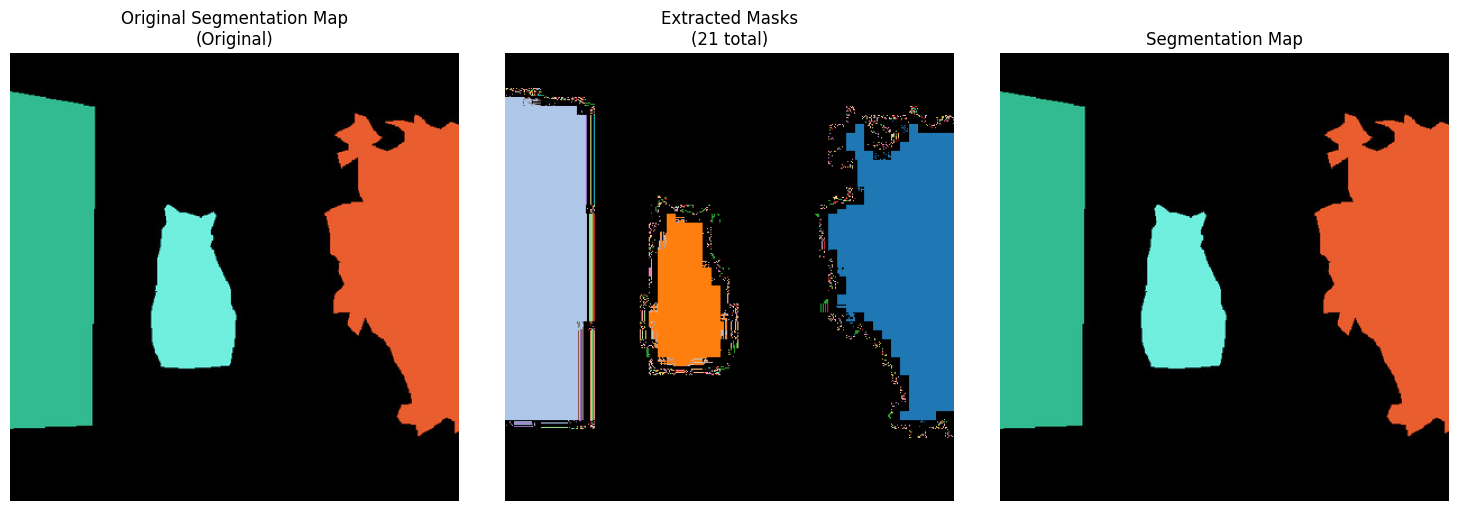

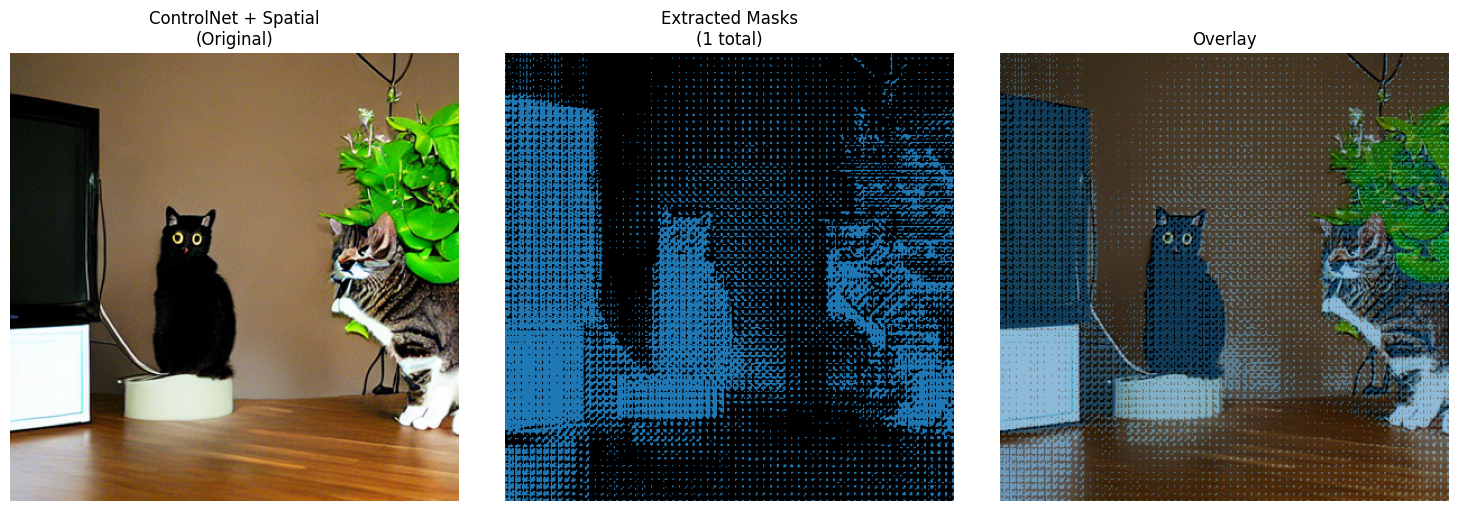

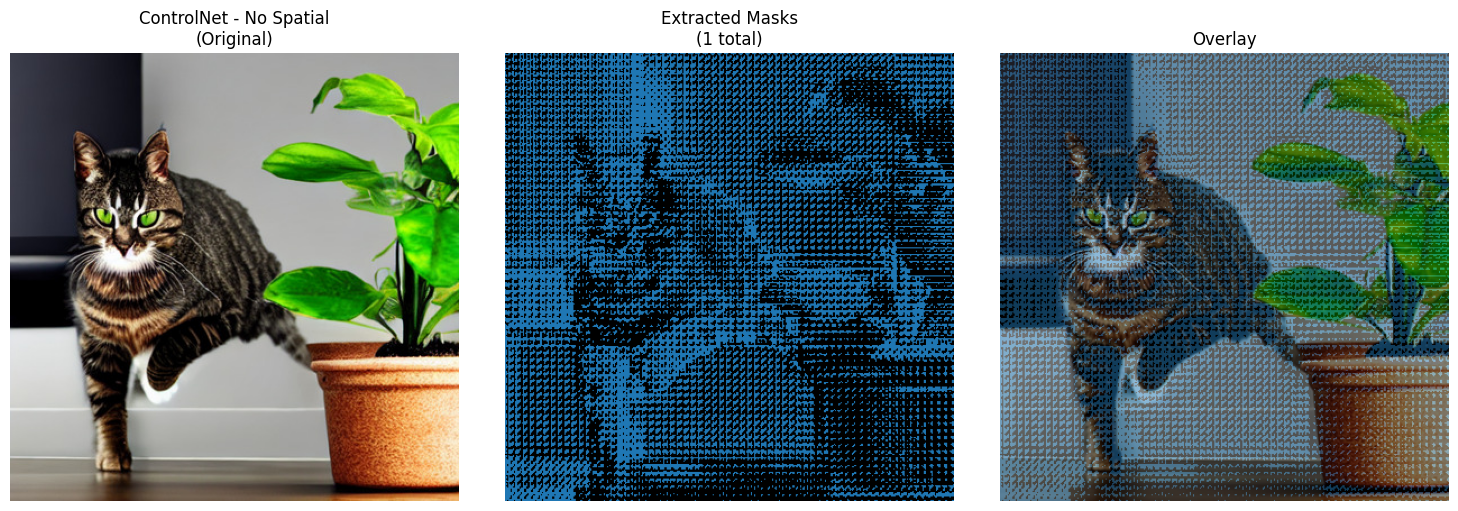

In [10]:
import matplotlib.pyplot as plt

def visualize_masks(image_path: str, masks: List[np.ndarray], title: str, is_segmap: bool = False):
    """Visualize image with segmentation overlay."""
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create colored overlay
    overlay = np.zeros_like(image_rgb)
    colors = plt.cm.tab20(np.linspace(0, 1, len(masks)))
    
    for idx, mask in enumerate(masks[:20]):  # Show top 20 segments
        color = (colors[idx][:3] * 255).astype(np.uint8)
        if mask.ndim == 3:
            mask = mask[0] if mask.shape[0] == 3 else mask[..., 0]

        overlay[mask > 0] = color
    
    # For segmentation map, show it as-is, otherwise blend
    if is_segmap:
        blended = image_rgb  # Show original colored segments
    else:
        blended = cv2.addWeighted(image_rgb, 0.5, overlay, 0.5, 0)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title(f'{title}\n(Original)')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title(f'Extracted Masks\n({len(masks)} total)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title('Segmentation Map' if is_segmap else 'Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualize all three
visualize_masks(original_segmentation_map, masks_original, "Original Segmentation Map", is_segmap=True)
visualize_masks(controlnet_spatial_image, masks_spatial, "ControlNet + Spatial")
visualize_masks(controlnet_no_spatial_image, masks_no_spatial, "ControlNet - No Spatial")

## 8. Run Hungarian Matching & Compute IoU

This is the core evaluation step:
1. Match segments from **Original** ↔ **ControlNet+Spatial**
2. Match segments from **Original** ↔ **ControlNet-NoSpatial**
3. Compare IoU scores to determine quality

In [11]:
print("\n" + "="*70)
print("HUNGARIAN MATCHING ALGORITHM")
print("="*70)

# Matching 1: Original vs ControlNet + Spatial
print("\n1️⃣  Original vs ControlNet + Spatial Conditioning")
print("-" * 70)
mean_iou_spatial, pairs_spatial, ious_spatial = hungarian_matching(masks_original, masks_spatial)
print(f"   Matched pairs: {len(pairs_spatial)}")
print(f"   Mean IoU: {mean_iou_spatial:.4f}")
print(f"   Max IoU: {max(ious_spatial):.4f}" if ious_spatial else "   Max IoU: 0.0000")
print(f"   Min IoU: {min(ious_spatial):.4f}" if ious_spatial else "   Min IoU: 0.0000")

# Matching 2: Original vs ControlNet - No Spatial
print("\n2️⃣  Original vs ControlNet - No Spatial Conditioning")
print("-" * 70)
mean_iou_no_spatial, pairs_no_spatial, ious_no_spatial = hungarian_matching(masks_original, masks_no_spatial)
print(f"   Matched pairs: {len(pairs_no_spatial)}")
print(f"   Mean IoU: {mean_iou_no_spatial:.4f}")
print(f"   Max IoU: {max(ious_no_spatial):.4f}" if ious_no_spatial else "   Max IoU: 0.0000")
print(f"   Min IoU: {min(ious_no_spatial):.4f}" if ious_no_spatial else "   Min IoU: 0.0000")

print("\n" + "="*70)


HUNGARIAN MATCHING ALGORITHM

1️⃣  Original vs ControlNet + Spatial Conditioning
----------------------------------------------------------------------
   Matched pairs: 1
   Mean IoU: 0.1667
   Max IoU: 0.1667
   Min IoU: 0.1667

2️⃣  Original vs ControlNet - No Spatial Conditioning
----------------------------------------------------------------------
   Matched pairs: 1
   Mean IoU: 0.1104
   Max IoU: 0.1104
   Min IoU: 0.1104



## 9. Final Results & Comparison

In [12]:
improvement = mean_iou_spatial - mean_iou_no_spatial
improvement_percent = (improvement / mean_iou_no_spatial * 100) if mean_iou_no_spatial > 0 else 0

print("\n" + "="*70)
print("🎯 FINAL QUALITY METRICS")
print("="*70)
print(f"\n📊 IoU Scores:")
print(f"   Original vs ControlNet+Spatial:    {mean_iou_spatial:.4f}")
print(f"   Original vs ControlNet-NoSpatial:  {mean_iou_no_spatial:.4f}")
print(f"\n📈 Improvement from Spatial Conditioning:")
print(f"   Absolute: {improvement:+.4f}")
print(f"   Relative: {improvement_percent:+.2f}%")
print("\n" + "="*70)

if improvement > 0:
    print("\n✅ RESULT: Spatial conditioning IMPROVES spatial structure preservation")
    print(f"   → ControlNet with segmentation maps better preserves object layout!")
elif improvement < 0:
    print("\n❌ RESULT: Spatial conditioning DECREASES spatial structure preservation")
    print(f"   → Unexpected: spatial conditioning performed worse")
else:
    print("\n➖ RESULT: No difference detected")
    print(f"   → Both methods preserve spatial structure equally")

print("="*70)


🎯 FINAL QUALITY METRICS

📊 IoU Scores:
   Original vs ControlNet+Spatial:    0.1667
   Original vs ControlNet-NoSpatial:  0.1104

📈 Improvement from Spatial Conditioning:
   Absolute: +0.0563
   Relative: +51.02%


✅ RESULT: Spatial conditioning IMPROVES spatial structure preservation
   → ControlNet with segmentation maps better preserves object layout!


## 10. Detailed Visualization of Results

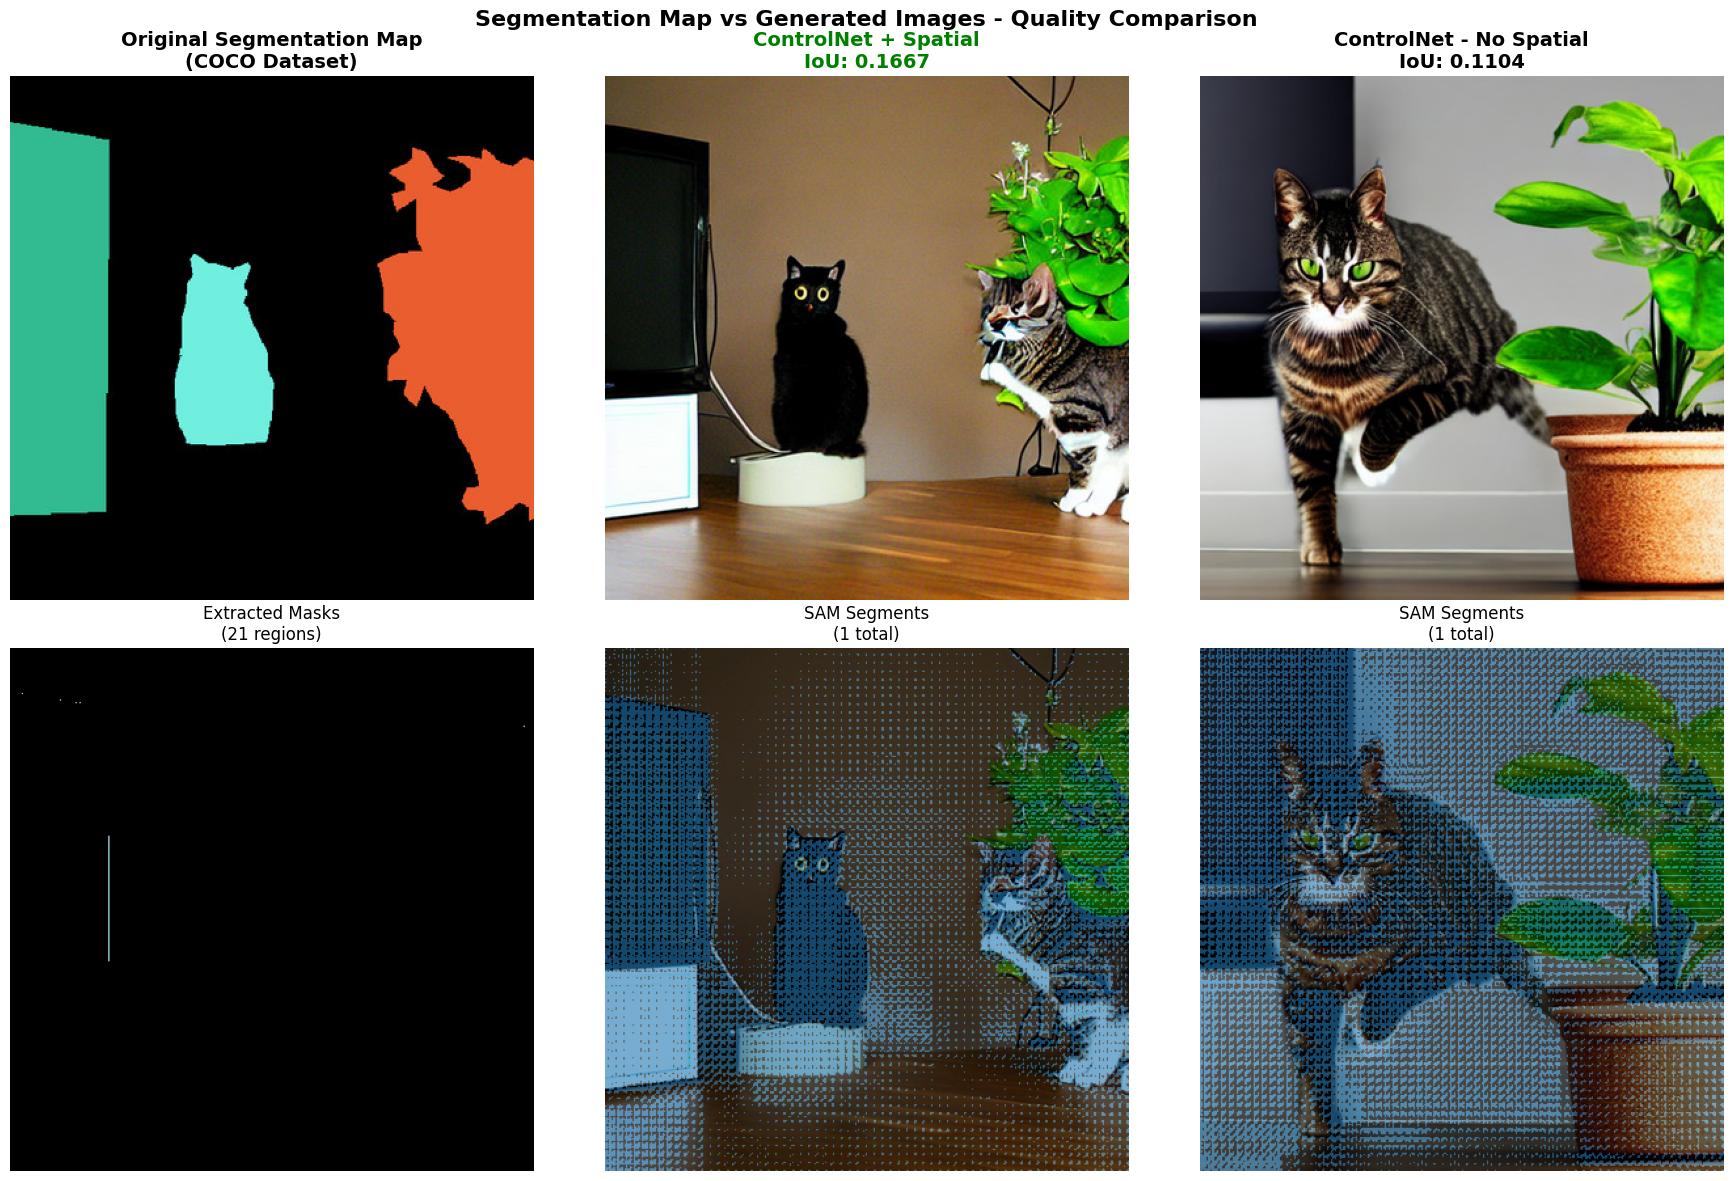

In [14]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Load images
img_orig = cv2.cvtColor(cv2.imread(original_segmentation_map), cv2.COLOR_BGR2RGB)
img_spatial = cv2.cvtColor(cv2.imread(controlnet_spatial_image), cv2.COLOR_BGR2RGB)
img_no_spatial = cv2.cvtColor(cv2.imread(controlnet_no_spatial_image), cv2.COLOR_BGR2RGB)

# Row 1: Original images
axes[0, 0].imshow(img_orig)
axes[0, 0].set_title('Original Segmentation Map\n(COCO Dataset)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_spatial)
axes[0, 1].set_title(f'ControlNet + Spatial\nIoU: {mean_iou_spatial:.4f}', 
                     fontsize=14, fontweight='bold', color='green' if improvement > 0 else 'red')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_no_spatial)
axes[0, 2].set_title(f'ControlNet - No Spatial\nIoU: {mean_iou_no_spatial:.4f}', 
                     fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Mask overlays
def create_overlay(masks, image, blend: bool = True):
    overlay = np.zeros_like(image)
    colors = plt.cm.tab20(np.linspace(0, 1, min(len(masks), 20)))
    for idx, mask in enumerate(masks[:20]):
        color = (colors[idx][:3] * 255).astype(np.uint8)
        if mask.ndim == 3:
            mask = mask[0] if mask.shape[0] == 3 else mask[..., 0]

    overlay[mask > 0] = color
    
    if blend:
        return cv2.addWeighted(image, 0.4, overlay, 0.6, 0)
    return overlay

axes[1, 0].imshow(create_overlay(masks_original, img_orig, blend=False))
axes[1, 0].set_title(f'Extracted Masks\n({len(masks_original)} regions)', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(create_overlay(masks_spatial, img_spatial))
axes[1, 1].set_title(f'SAM Segments\n({len(masks_spatial)} total)', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(create_overlay(masks_no_spatial, img_no_spatial))
axes[1, 2].set_title(f'SAM Segments\n({len(masks_no_spatial)} total)', fontsize=12)
axes[1, 2].axis('off')

plt.suptitle('Segmentation Map vs Generated Images - Quality Comparison', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 11. IoU Distribution Analysis

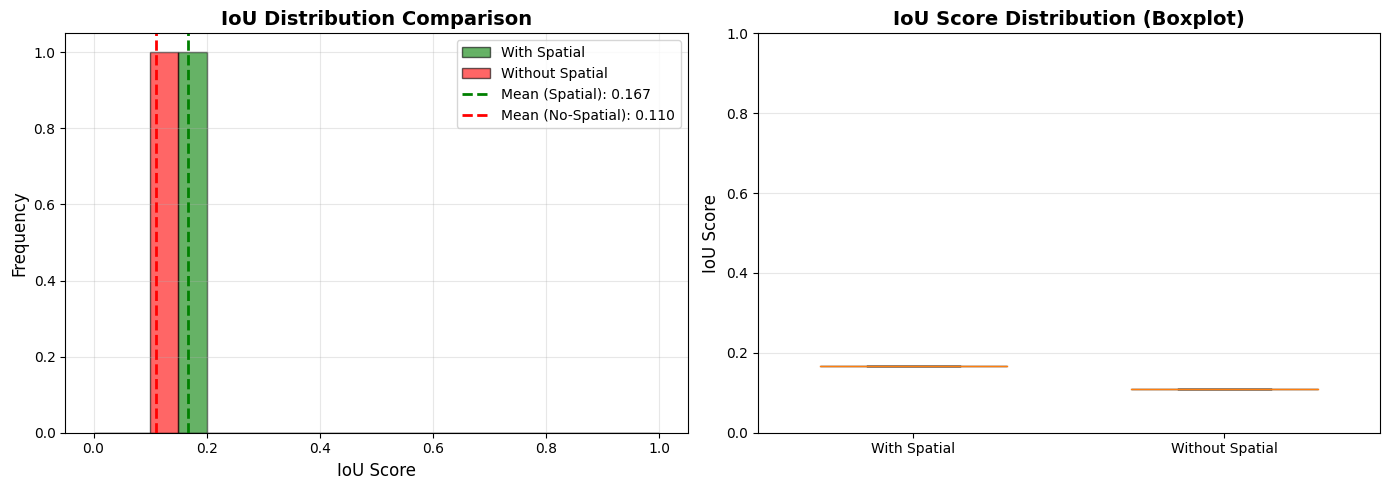


📊 Statistical Summary:

With Spatial Conditioning:
  Mean:   0.1667
  Median: 0.1667
  Std:    0.0000

Without Spatial Conditioning:
  Mean:   0.1104
  Median: 0.1104
  Std:    0.0000


In [15]:
# Plot IoU distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
bins = np.linspace(0, 1, 21)
ax1.hist(ious_spatial, bins=bins, alpha=0.6, label='With Spatial', color='green', edgecolor='black')
ax1.hist(ious_no_spatial, bins=bins, alpha=0.6, label='Without Spatial', color='red', edgecolor='black')
ax1.axvline(mean_iou_spatial, color='green', linestyle='--', linewidth=2, label=f'Mean (Spatial): {mean_iou_spatial:.3f}')
ax1.axvline(mean_iou_no_spatial, color='red', linestyle='--', linewidth=2, label=f'Mean (No-Spatial): {mean_iou_no_spatial:.3f}')
ax1.set_xlabel('IoU Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('IoU Distribution Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
data_to_plot = [ious_spatial, ious_no_spatial]
bp = ax2.boxplot(data_to_plot, labels=['With Spatial', 'Without Spatial'], 
                  patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax2.set_ylabel('IoU Score', fontsize=12)
ax2.set_title('IoU Score Distribution (Boxplot)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 Statistical Summary:")
print("\nWith Spatial Conditioning:")
print(f"  Mean:   {np.mean(ious_spatial):.4f}")
print(f"  Median: {np.median(ious_spatial):.4f}")
print(f"  Std:    {np.std(ious_spatial):.4f}")

print("\nWithout Spatial Conditioning:")
print(f"  Mean:   {np.mean(ious_no_spatial):.4f}")
print(f"  Median: {np.median(ious_no_spatial):.4f}")
print(f"  Std:    {np.std(ious_no_spatial):.4f}")

## 12. Summary & Interpretation

### How This Metric Works:

1. **Extract Original Masks**: Parse colored regions from COCO segmentation map
2. **SAM Segmentation**: Generate masks for both ControlNet outputs
3. **Class-Agnostic Matching**: Treats all segments equally (no class labels needed)
4. **Hungarian Algorithm**: Finds optimal one-to-one matching that maximizes total IoU
5. **Quality Score**: Mean IoU indicates how well spatial structure is preserved

### Interpreting Results:

- **IoU > 0.6**: Excellent spatial preservation - generated image closely matches segmentation structure
- **0.4 < IoU < 0.6**: Good spatial preservation - reasonable object layout matching
- **0.2 < IoU < 0.4**: Moderate spatial preservation - some spatial structure retained
- **IoU < 0.2**: Poor spatial preservation - significant deviation from original layout

### Key Advantages:

✅ **Works with COCO segmentation maps** - directly uses colored regions  
✅ **Class-agnostic** - no need to know object classes  
✅ **Optimal matching** via Hungarian algorithm  
✅ **Interpretable** - IoU is well-understood  
✅ **Quantitative** - produces comparable scores  

### Use Cases:

- Evaluate ControlNet spatial conditioning quality
- Validate that segmentation-conditioned generation preserves layout
- Compare ControlNet with/without spatial conditioning
- Benchmark different generation methods